In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
#Importing all the libraries
import os
import datetime
import pandas as pd 
import numpy as np
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
#Data Visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
#Warnings
import warnings
warnings.filterwarnings("ignore")

In [0]:
pd.options.display.max_rows = 999

# Reading Dataset

In [0]:
train_file = pd.read_csv('/content/drive/My Drive/Project1_Data/Consumer_Complaints_train.csv')
test_file = pd.read_csv('/content/drive/My Drive/Project1_Data/Consumer_Complaints_test_share.csv')

print(train_file.shape)
print(test_file.shape)

(472444, 18)
(119606, 17)


In [0]:
train_file.head()

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,15-05-2014,Credit card,NaN,Billing statement,NaN,NaN,NaN,Wells Fargo & Company,MI,48342,Older American,NaN,Web,16-05-2014,Closed with explanation,Yes,No,856103.0
1,18-09-2014,Bank account or service,(CD) Certificate of deposit,"Making/receiving payments, sending money",NaN,NaN,NaN,Santander Bank US,PA,18042,NaN,NaN,Referral,24-09-2014,Closed,Yes,No,1034666.0
2,13-03-2014,Credit reporting,NaN,Incorrect information on credit report,Account status,NaN,NaN,Equifax,CA,92427,NaN,NaN,Referral,03-04-2014,Closed with non-monetary relief,Yes,No,756363.0
3,17-07-2015,Credit card,NaN,Billing statement,NaN,"My credit card statement from US Bank, XXXX. X...",Company chooses not to provide a public response,U.S. Bancorp,GA,305XX,Older American,Consent provided,Web,17-07-2015,Closed with monetary relief,Yes,No,1474177.0
4,20-11-2014,Credit card,NaN,Transaction issue,NaN,NaN,NaN,Bank of America,MA,2127,NaN,NaN,Web,28-11-2014,Closed with explanation,Yes,No,1132572.0


In [0]:
test_file.head()

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Complaint ID
0,2014-01-18,Bank account or service,Cashing a check without an account,Deposits and withdrawals,NaN,NaN,NaN,Bank of America,CA,95691,NaN,NaN,Web,2014-01-17,Closed with explanation,Yes,675956
1,2016-03-31,Debt collection,Credit card,Cont'd attempts collect debt not owed,Debt was paid,NaN,NaN,"National Credit Adjusters, LLC",FL,32086,NaN,Consent not provided,Web,2016-03-31,Closed with explanation,Yes,1858795
2,2012-03-08,Mortgage,Conventional adjustable mortgage (ARM),"Loan servicing, payments, escrow account",NaN,NaN,NaN,Wells Fargo & Company,CA,94618,NaN,NaN,Web,2012-03-09,Closed without relief,Yes,32637
3,2016-01-07,Credit reporting,NaN,Unable to get credit report/credit score,Problem getting report or credit score,NaN,Company chooses not to provide a public response,"TransUnion Intermediate Holdings, Inc.",FL,33584,Older American,NaN,Postal mail,2016-01-12,Closed with non-monetary relief,Yes,1731374
4,2013-08-23,Mortgage,FHA mortgage,"Loan modification,collection,foreclosure",NaN,NaN,NaN,Bank of America,FL,33543,NaN,NaN,Web,2013-08-23,Closed with explanation,Yes,501487


In [0]:
train_file.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 472444 entries, 0 to 472443
Data columns (total 18 columns):
Date received                   472444 non-null object
Product                         472444 non-null object
Sub-product                     335725 non-null object
Issue                           472444 non-null object
Sub-issue                       183427 non-null object
Consumer complaint narrative    74187 non-null object
Company public response         89301 non-null object
Company                         472443 non-null object
State                           468649 non-null object
ZIP code                        468640 non-null object
Tags                            66364 non-null object
Consumer consent provided?      133820 non-null object
Submitted via                   472443 non-null object
Date sent to company            472443 non-null object
Company response to consumer    472443 non-null object
Timely response?                472443 non-null object
Consumer dis

Equalizing the columns of train and test file and combining both files into one for Data Preprocessing 

In [0]:
train_file['data'] = 'train'
test_file['data'] = 'test'
test_file['Consumer disputed?'] = np.nan

file = pd.concat([train_file, test_file], axis=0)
file.shape

(592050, 19)

# Dealing with Missing Values

In [0]:
train_file.isnull().sum()

Date received                        0
Product                              0
Sub-product                     136719
Issue                                0
Sub-issue                       289017
Consumer complaint narrative    398257
Company public response         383143
Company                              1
State                             3795
ZIP code                          3804
Tags                            406080
Consumer consent provided?      338624
Submitted via                        1
Date sent to company                 1
Company response to consumer         1
Timely response?                     1
Consumer disputed?                   1
Complaint ID                         1
data                                 0
dtype: int64

In [0]:
file.isnull().sum()

Company                              1
Company public response         479973
Company response to consumer         1
Complaint ID                         1
Consumer complaint narrative    499306
Consumer consent provided?      424366
Consumer disputed?              119607
Date received                        0
Date sent to company                 1
Issue                                0
Product                              0
State                             4720
Sub-issue                       362077
Sub-product                     171471
Submitted via                        2
Tags                            508815
Timely response?                     1
ZIP code                          4730
data                                 0
dtype: int64

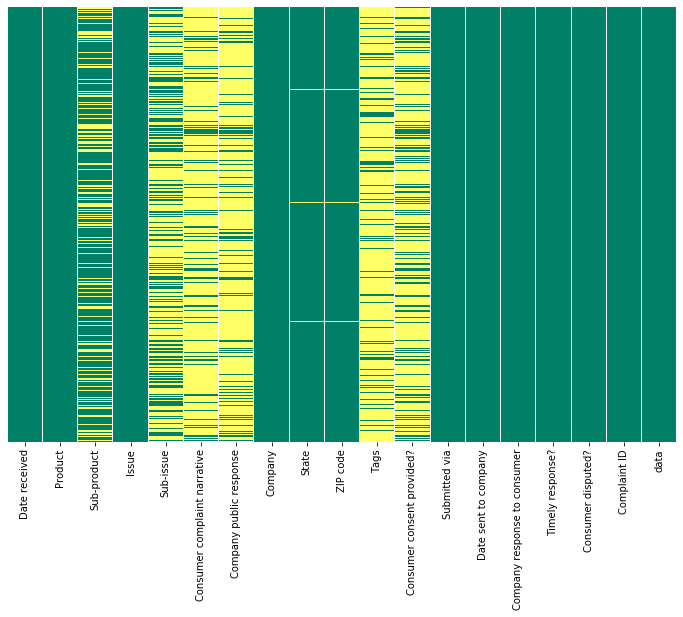

In [0]:
fig, ax = plt.subplots(figsize = (12, 8))
sns.heatmap(train_file.isna(),
           cbar = False,
           yticklabels = False,
           cmap = 'summer')
plt.show()

Dropping unwanted columns or columns with large number of missing values.
Here I have dropped the Consumer complaint narrative column as well,  because we have Issue and Sub Issue which can give us quite good information that people facing which issue are disputing with the company

In [0]:
train_file.drop(columns=['Complaint ID', 'Consumer complaint narrative', 'ZIP code', 'Company public response'], inplace=True)
file.drop(columns=['Complaint ID', 'Consumer complaint narrative', 'ZIP code', 'Company public response'], inplace=True)

In [0]:
train_file['Consumer complaint narrative'].value_counts()[:5]

This company continues to report on my credit report after I sent them a letter telling them that this account was not mine and I have no idea what it is or who it belongs to! \n\nI asked for proof of a signed contract, I asked for a license to collect in my state, I asked for copies of all information referenced for this debt and still to date, I have not received anything but harassment from this company! \n\nTHIS IS NOT MY DEBT! \n\nI WANT THIS ACCOUNT REMOVED FROM MY CREDIT REPORT AND THIS COMPANY TO STOP CONTACTING ME IMMEDIATELY! \n                                                                                                                                                                                                            38
This company continues to report on my credit report after I sent them a letter telling them that this account was not mine and I have no idea what it is or who it belongs to! \n\nI asked for proof of a signed contract, I asked for a license to coll

In [0]:
#Function to replace missing values

def fill_missing(df):

    #fill 'sub-product' with 'No sub-product'
    df['Sub-product'].fillna('I do not know', inplace=True)

    #fill 'sub-product' with 'No sub-product'
    df['Sub-issue'].fillna('No Sub-issue', inplace=True)

    #fill 'State' with 'CA' (Most Frequent Value)
    df['State'].fillna('CA', inplace=True)

    #Combine missing value of "Issue" with "Other"
    df['Issue'].fillna('Loan modification,collection,foreclosure',inplace=True)

    # Replace missing vlaues of 'Tags' with 'Unknown'
    df['Tags'].fillna('Unknown',inplace=True)

    # Replace missing vlaues of 'Submitted via' with 'other'
    df['Submitted via'].fillna('Web',inplace=True)

    #Combine missing value,other,and withdrawn of "Consumer consent provided?" column
    #with Consumer consent not provided, since only users's complaints narrative will be provided
    #with the type of "Consumer consent provided"

    df['Consumer consent provided?'].fillna('Consent not provided',inplace=True)

    

In [0]:
fill_missing(train_file)
fill_missing(file)

In [0]:
#Replacing NaNs of other columns with forwardfill method
file.fillna(method='ffill', inplace=True)
train_file.fillna(method='ffill', inplace=True)

In [0]:
train_file.isnull().sum()

Date received                   0
Product                         0
Sub-product                     0
Issue                           0
Sub-issue                       0
Company                         0
State                           0
Tags                            0
Consumer consent provided?      0
Submitted via                   0
Date sent to company            0
Company response to consumer    0
Timely response?                0
Consumer disputed?              0
data                            0
dtype: int64

In [0]:
file.isnull().sum()

Company                         0
Company response to consumer    0
Consumer consent provided?      0
Consumer disputed?              0
Date received                   0
Date sent to company            0
Issue                           0
Product                         0
State                           0
Sub-issue                       0
Sub-product                     0
Submitted via                   0
Tags                            0
Timely response?                0
data                            0
dtype: int64

In [0]:
train_file.nunique()

Date received                   1759
Product                           12
Sub-product                       47
Issue                             95
Sub-issue                         69
Company                         3266
State                             62
Tags                               4
Consumer consent provided?         4
Submitted via                      6
Date sent to company            1706
Company response to consumer       7
Timely response?                   2
Consumer disputed?                 2
data                               1
dtype: int64

Replacing "Yes/No" values with 1/0

In [0]:
replace = {'Yes' : 1, 'No' : 0}

file['Timely response?'] = file['Timely response?'].apply(lambda x: replace[x])
file['Consumer disputed?'] = file['Consumer disputed?'].apply(lambda x: replace[x])

train_file['Timely response?'] = train_file['Timely response?'].apply(lambda x: replace[x])
train_file['Consumer disputed?'] = train_file['Consumer disputed?'].apply(lambda x: replace[x])

In [0]:
#Target Variable
train_file['Consumer disputed?'].value_counts()

0    372304
1    100140
Name: Consumer disputed?, dtype: int64

# Exploratory Data Analysis


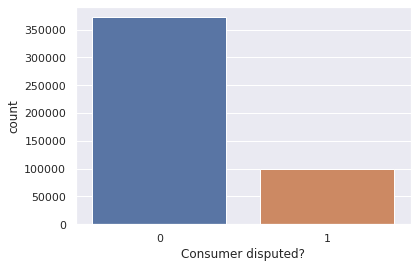

In [0]:
sns.countplot(train_file['Consumer disputed?'])

Maybe it is an Imbalance dataset problem

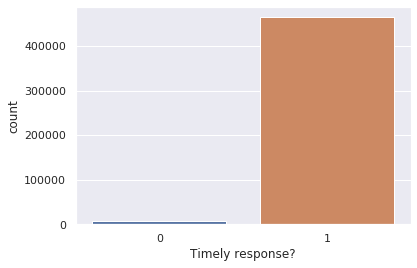

In [0]:
sns.countplot(train_file['Timely response?'])

Almost every companies gives Timely Response to the Consumer

Checking which Product has the maximum complaints

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 <a list of 12 Text xticklabel objects>)

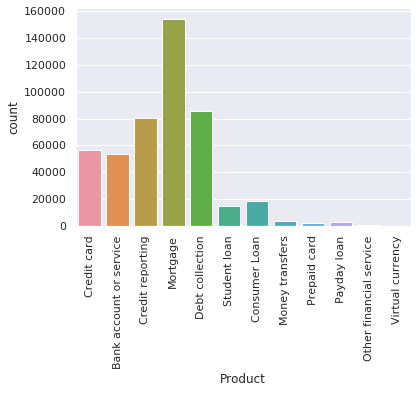

In [0]:
sns.countplot(train_file['Product'])
plt.xticks(rotation=90)

Product **Mortgage** has the maximum complaints followed by Debt collection and Credict reporting, 
Checking what are the issues regarding these products

1. Issues related to Mortgage

In [0]:
set(train_file['Issue'][train_file['Product'] == 'Mortgage'])

{'Application, originator, mortgage broker',
 'Credit decision / Underwriting',
 'Loan modification,collection,foreclosure',
 'Loan servicing, payments, escrow account',
 'Other',
 'Settlement process and costs'}

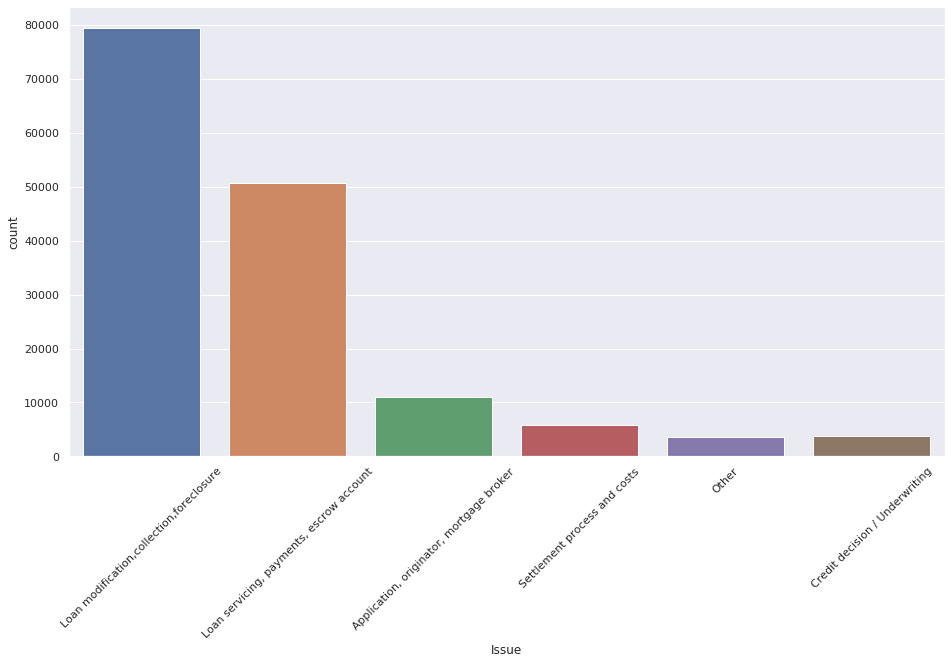

In [0]:
sns.countplot(train_file['Issue'][train_file['Product'] == 'Mortgage'])
plt.xticks(rotation=45)
sns.set(rc={'figure.figsize':(15.7,8.27)})

**Loan modification, collection, foreclosure** is the major issue of the product Mortgage

In [0]:
file['Loan modification,collection,foreclosure'] = (file['Issue'] == 'Loan modification,collection,foreclosure').astype(int)
file['Loan servicing, payments, escrow account'] = (file['Issue'] == 'Loan servicing, payments, escrow account').astype(int)

Checking the same for other products

2. Issues related to Debt collection

In [0]:
set(train_file['Issue'][train_file['Product'] == 'Debt collection'])

{'Communication tactics',
 "Cont'd attempts collect debt not owed",
 'Disclosure verification of debt',
 'False statements or representation',
 'Improper contact or sharing of info',
 'Taking/threatening an illegal action'}

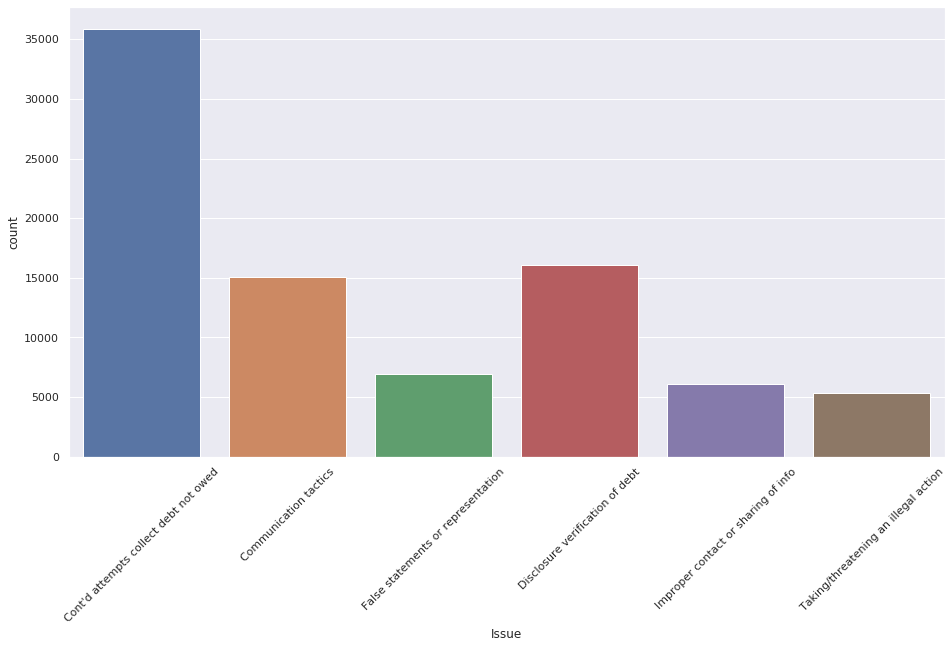

In [0]:
sns.countplot(train_file['Issue'][train_file['Product'] == 'Debt collection'])
plt.xticks(rotation=45)
sns.set(rc={'figure.figsize':(15.7,8.27)})

In [0]:
file["Cont'd attempts collect debt not owed"] = (file['Issue'] == "Cont'd attempts collect debt not owed").astype(int)
file['Disclosure verification of debt'] = (file['Issue'] == 'Disclosure verification of debt').astype(int)

3. Issues related to Credit reporting

In [0]:
set(train_file['Issue'][train_file['Product'] == 'Credit reporting'])

{'Credit monitoring or identity protection',
 "Credit reporting company's investigation",
 'Improper use of my credit report',
 'Incorrect information on credit report',
 'Unable to get credit report/credit score'}

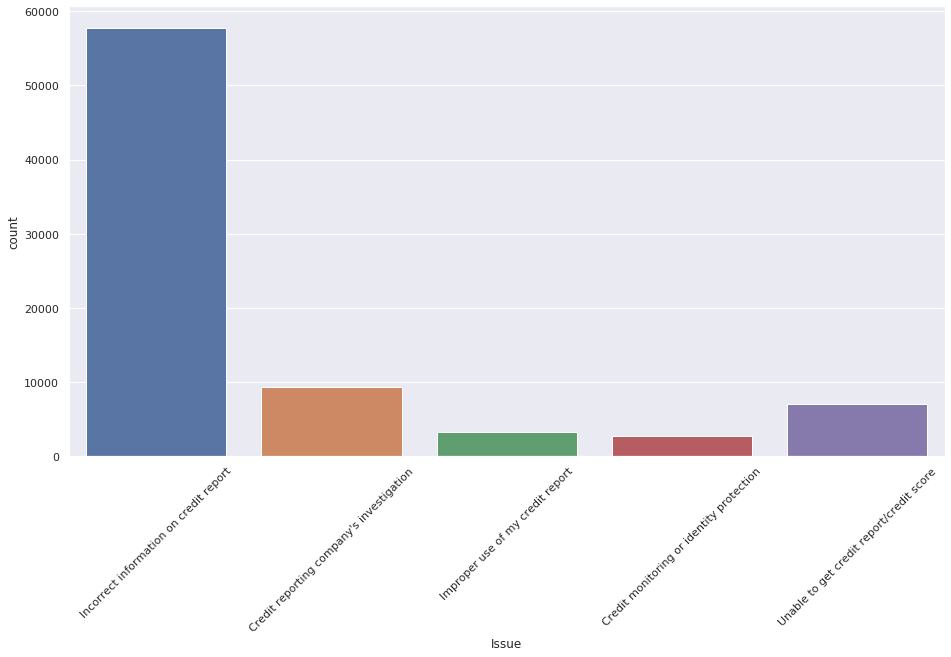

In [0]:
sns.countplot(train_file['Issue'][train_file['Product'] == 'Credit reporting'])
plt.xticks(rotation=45)
sns.set(rc={'figure.figsize':(15.7,8.27)})

In [0]:
file["Incorrect information on credit report"] = (file['Issue'] == "Incorrect information on credit report").astype(int)

4. Issues related to credit card

In [0]:
set(train_file['Issue'][train_file['Product'] == 'Credit card'])

{'APR or interest rate',
 'Advertising and marketing',
 'Application processing delay',
 'Arbitration',
 'Balance transfer',
 'Balance transfer fee',
 'Bankruptcy',
 'Billing disputes',
 'Billing statement',
 'Cash advance',
 'Cash advance fee',
 'Closing/Cancelling account',
 'Collection debt dispute',
 'Collection practices',
 'Convenience checks',
 'Credit card protection / Debt protection',
 'Credit determination',
 'Credit line increase/decrease',
 'Credit reporting',
 'Customer service / Customer relations',
 'Delinquent account',
 'Forbearance / Workout plans',
 'Identity theft / Fraud / Embezzlement',
 'Late fee',
 'Other',
 'Other fee',
 'Overlimit fee',
 'Payoff process',
 'Privacy',
 'Rewards',
 'Sale of account',
 'Transaction issue',
 'Unsolicited issuance of credit card'}

There are many issues for these product

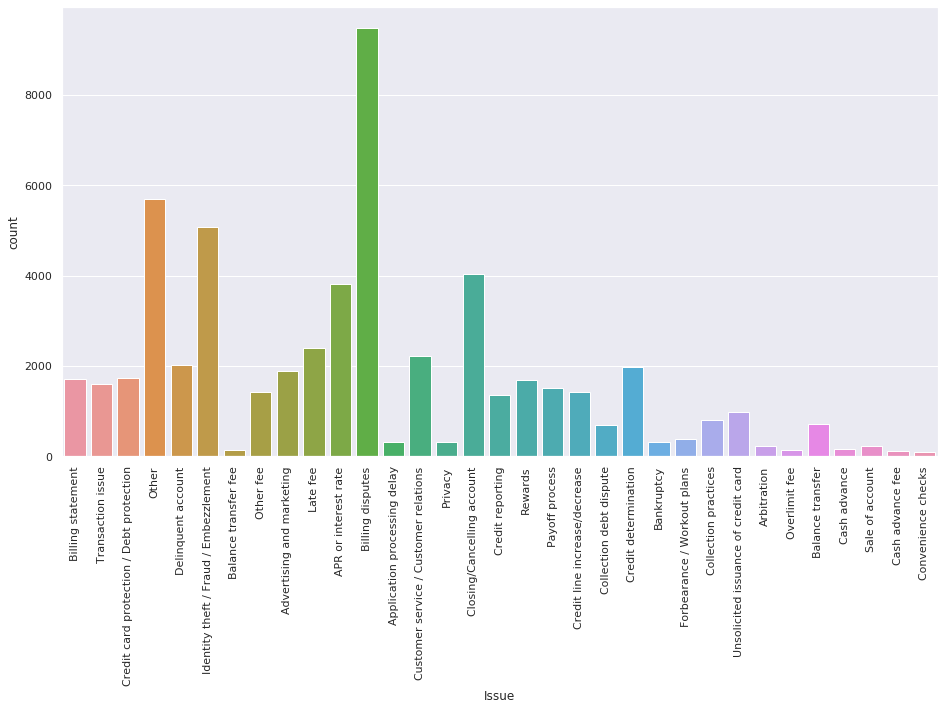

In [0]:
sns.countplot(train_file['Issue'][train_file['Product'] == 'Credit card'])
plt.xticks(rotation=90)
sns.set(rc={'figure.figsize':(20.7,8.27)})

In [0]:
file["Billing disputes"] = (file['Issue'] == "Billing disputes").astype(int)

5. Issues related to Bank account or service

In [0]:
set(train_file['Issue'][train_file['Product'] == 'Bank account or service'])

{'Account opening, closing, or management',
 'Deposits and withdrawals',
 'Making/receiving payments, sending money',
 'Problems caused by my funds being low',
 'Using a debit or ATM card'}

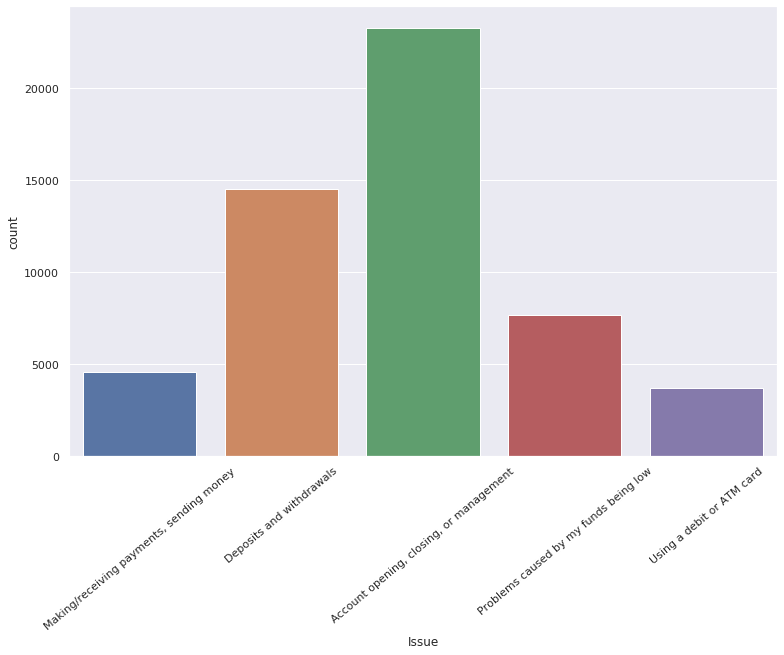

In [0]:
sns.countplot(train_file['Issue'][train_file['Product'] == 'Bank account or service'])
plt.xticks(rotation=40)
sns.set(rc={'figure.figsize':(12.7,8.27)})

In [0]:
file["Account opening, closing, or management"] = (file['Issue'] == "Account opening, closing, or management").astype(int)
file["Deposits and withdrawals"] = (file['Issue'] == "Deposits and withdrawals").astype(int)

6. Issues related to Consumer Loan

In [0]:
set(train_file['Issue'][train_file['Product'] == 'Consumer Loan'])

{'Account terms and changes',
 'Applied for loan/did not receive money',
 "Can't contact lender",
 "Can't stop charges to bank account",
 'Charged bank acct wrong day or amt',
 "Charged fees or interest I didn't expect",
 'Lender damaged or destroyed property',
 'Lender damaged or destroyed vehicle',
 'Lender repossessed or sold the vehicle',
 'Lender sold the property',
 'Managing the line of credit',
 'Managing the loan or lease',
 'Payment to acct not credited',
 'Problems when you are unable to pay',
 "Received a loan I didn't apply for",
 'Shopping for a line of credit',
 'Shopping for a loan or lease',
 'Taking out the loan or lease'}

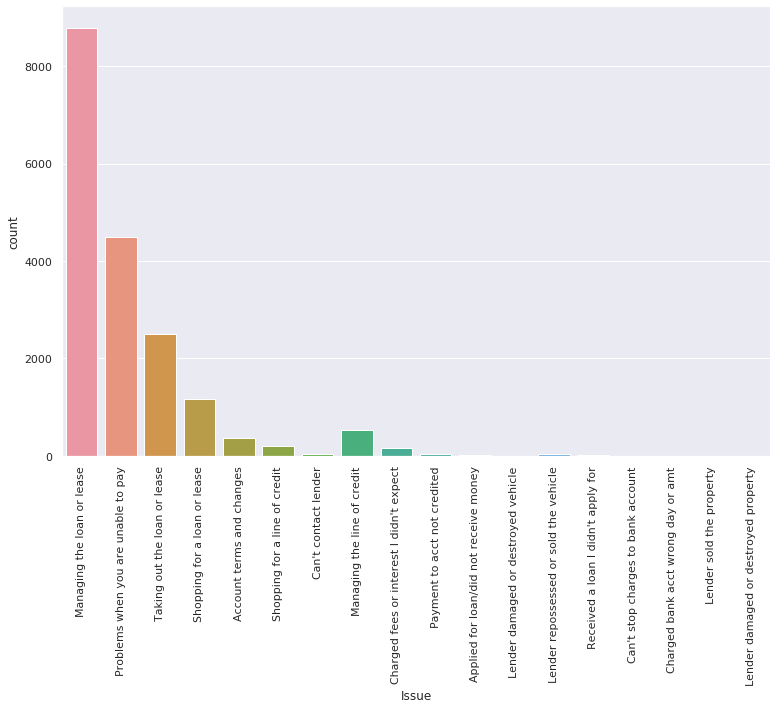

In [0]:
sns.countplot(train_file['Issue'][train_file['Product'] == 'Consumer Loan'])
plt.xticks(rotation=90)
sns.set(rc={'figure.figsize':(20.7,8.27)})

In [0]:
file["Managing the loan or lease"] = (file['Issue'] == "Managing the loan or lease").astype(int)

7. Issues related to Student loan

In [0]:
set(train_file['Issue'][train_file['Product'] == 'Student loan'])

{"Can't repay my loan",
 'Dealing with my lender or servicer',
 'Getting a loan',
 'Problems when you are unable to pay',
 'Repaying your loan'}

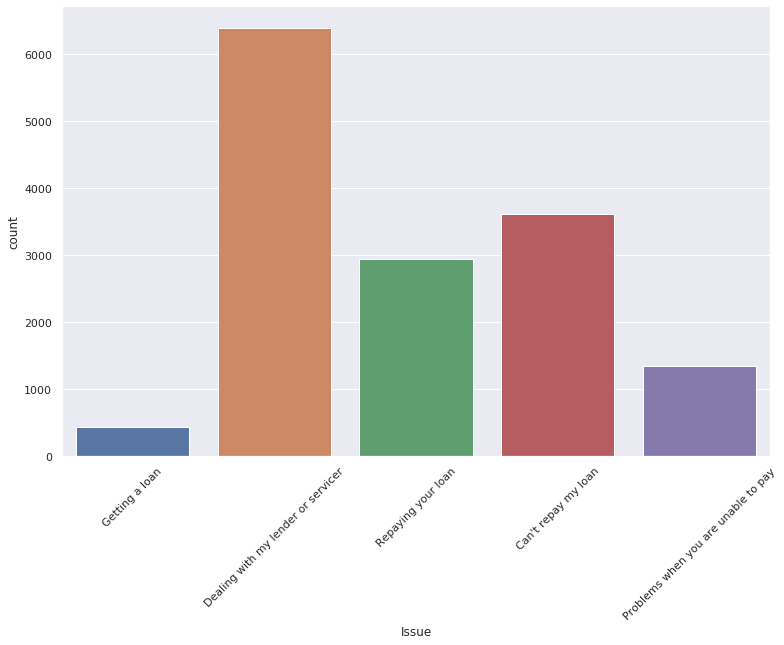

In [0]:
sns.countplot(train_file['Issue'][train_file['Product'] == 'Student loan'])
plt.xticks(rotation=45)
sns.set(rc={'figure.figsize':(12.7,8.27)})

In [0]:
file["Dealing with my lender or servicer"] = (file['Issue'] == "Dealing with my lender or servicer").astype(int)

I thought to make new features from Issue column by selecting the top 2 major issues for every product and making dummies, I had not implemented this because i don't know it will work or not so please help me with this

Checking for Top 10 companies having maximum complaints of consumers

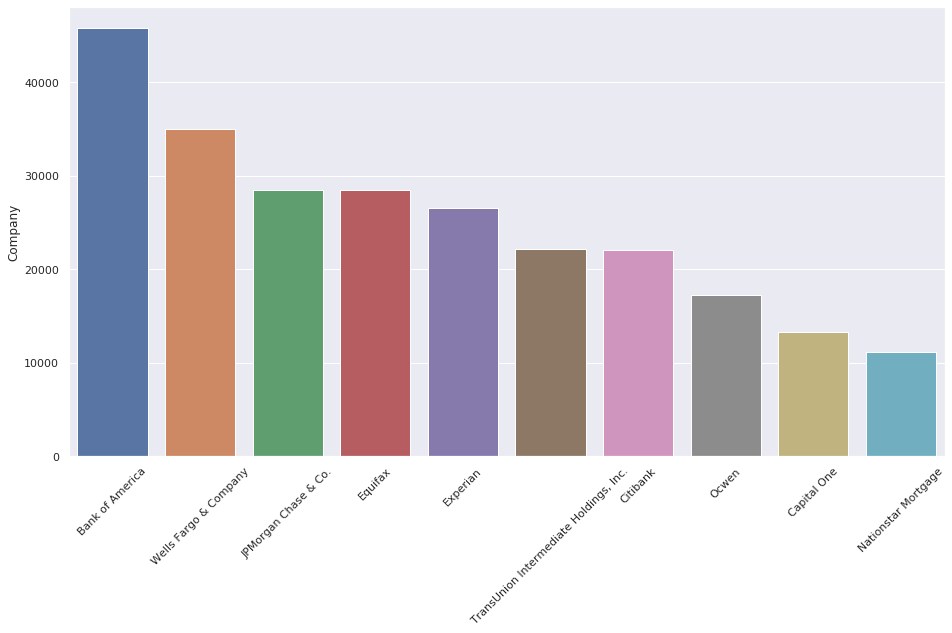

In [0]:
sns.barplot(x=train_file['Company'].value_counts().index[:10], y=train_file['Company'].value_counts()[:10])
plt.xticks(rotation=45)
sns.set(rc={'figure.figsize':(15.7,8.27)})

In [0]:
train_file['Company'].value_counts()[:10]

Bank of America                           45791
Wells Fargo & Company                     35000
JPMorgan Chase & Co.                      28485
Equifax                                   28429
Experian                                  26483
TransUnion Intermediate Holdings, Inc.    22198
Citibank                                  21993
Ocwen                                     17249
Capital One                               13218
Nationstar Mortgage                       11158
Name: Company, dtype: int64

Maybe we can consider only these companies as Top 10 worst companies and make dummies

In [0]:
file['Bank of America'] = (file['Company'] == 'Bank of America').astype(int)
file['Wells Fargo & Company'] = (file['Company'] == 'Bank of America').astype(int)
file['JPMorgan Chase & Co.'] = (file['Company'] == 'JPMorgan Chase & Co.').astype(int)
file['Experian'] = (file['Company'] == 'Experian').astype(int)
file['TransUnion Intermediate Holdings, Inc.'] = (file['Company'] == 'TransUnion Intermediate Holdings, Inc.').astype(int)
file['Citibank'] = (file['Company'] == 'Citibank').astype(int)
file['Ocwen'] = (file['Company'] == 'Ocwen').astype(int)
file['Capital One'] = (file['Company'] == 'Capital One').astype(int)
file['Nationstar Mortgage'] = (file['Company'] == 'Nationstar Mortgage').astype(int)

In [0]:
file.columns

Index(['Company', 'Company public response', 'Company response to consumer',
       'Consumer consent provided?', 'Consumer disputed?', 'Date received',
       'Date sent to company', 'Issue', 'Product', 'State', 'Sub-product',
       'Submitted via', 'Tags', 'Timely response?', 'data', 'Bank of America',
       'Wells Fargo & Company', 'JPMorgan Chase & Co.', 'Equifax', 'Experian',
       'TransUnion Intermediate Holdings, Inc.', 'Citibank', 'Ocwen',
       'Capital One', 'Nationstar Mortgage'],
      dtype='object')

Checking complaint submission methods

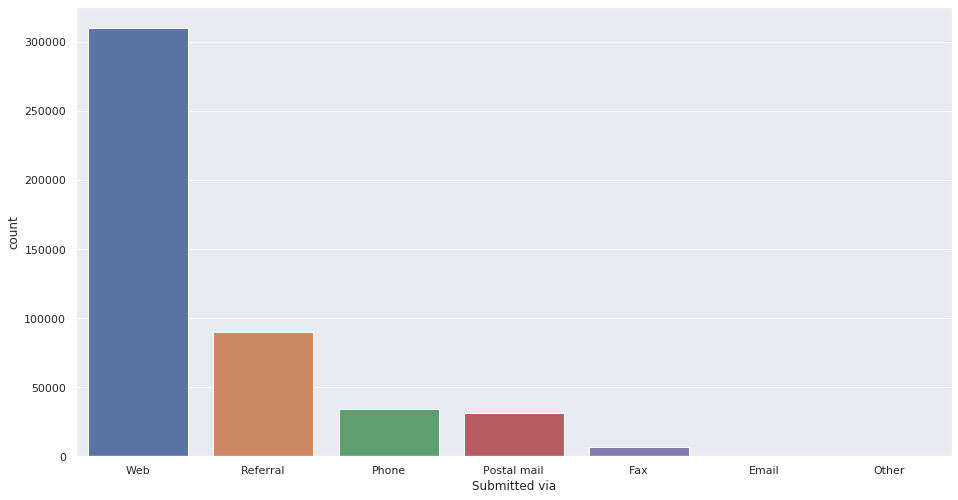

In [0]:
sns.countplot(train_file['Submitted via'])

Most of the complaints are submitted via Web

# Feature Encoding 

I have done Feature Encoding on the combined file having train and test data

In [0]:
train_file['Company response to consumer'].unique()

array(['Closed with explanation', 'Closed',
       'Closed with non-monetary relief', 'Closed with monetary relief',
       'Closed with relief', 'Closed without relief', 'Untimely response'],
      dtype=object)

In [0]:
pd.crosstab(train_file['Company response to consumer'], train_file['Consumer disputed?'], normalize='index').round(2)

Consumer disputed?,0,1
Company response to consumer,,
Closed,0.78,0.22
Closed with explanation,0.77,0.23
Closed with monetary relief,0.89,0.11
Closed with non-monetary relief,0.87,0.13
Closed with relief,0.87,0.13
Closed without relief,0.73,0.27
Untimely response,0.00,1.00


In [0]:
replace = {'Closed':'0', 'Untimely response':'0','Closed without relief':'0', 
    'Closed with explanation':'1', 'Closed with non-monetary relief':'2',
    'Closed with relief': '2', 'Closed with monetary relief':'2'}

file['Company response to consumer'] = train_file['Company response to consumer'].apply(lambda x: replace[x])

In [0]:
pd.crosstab(train_file['Consumer consent provided?'], train_file['Consumer disputed?'])

Consumer disputed?,0,1
Consumer consent provided?,,
Consent not provided,313550,80508
Consent provided,55603,18585
Consent withdrawn,2,1
Other,3149,1046


In [0]:
replace = {'Consent not provided': 0, 'Consent withdrawn': 0, 'Other': 0, 'Consent provided': 1}
file['Consumer consent provided?'] = train_file['Consumer consent provided?'].apply(lambda x: replace[x])

In [0]:
#file['Company public response'].unique()

array(['Company chooses not to provide',
       'Company chooses not to provide a public response',
       'Company has responded to the consumer and the CFPB and chooses not to provide a public response',
       'Company believes it acted appropriately as authorized by contract or law',
       'Company believes complaint caused principally by actions of third party outside the control or direction of the company',
       'Company believes the complaint is the result of a misunderstanding',
       'Company disputes the facts presented in the complaint',
       "Company can't verify or dispute the facts in the complaint",
       'Company believes complaint is the result of an isolated error',
       'Company believes complaint represents an opportunity for improvement to better serve consumers',
       'Company believes complaint relates to a discontinued policy or procedure',
       'Company has responded to the consumer and the CFPB and chooses not to provide a pu'],
      dtype=objec

In [0]:
#Encoding Company public response column
#I have grouped some of the values

#file['Company public response'] = file['Company public response'].map( {
#    "Company chooses not to provide" : '0',
#    "Company chooses not to provide a public response" : '0',
#    "Company has responded to the consumer and the CFPB and chooses not to provide a pu" : '0',
#    "Company has responded to the consumer and the CFPB and chooses not to provide a public response" : '0',
#    "Company believes it acted appropriately as authorized by contract or law" : '1',
#    "Company believes complaint caused principally by actions of third party outside the control or direction of the company" : '2',
#    "Company believes the complaint is the result of a misunderstanding" : '3',
#    "Company disputes the facts presented in the complaint" : '4',
#    "Company believes complaint is the result of an isolated error" : '5',
#    "Company can't verify or dispute the facts in the complaint" : '6',
#    "Company believes complaint represents an opportunity for improvement to better serve consumers" : '7',
#    "Company believes complaint relates to a discontinued policy or procedure" : '8'
#} )

In [0]:
pd.crosstab(train_file['State'], train_file['Consumer disputed?'], normalize='index').round(2)

Consumer disputed?,0,1
State,,
AA,0.62,0.38
AE,0.83,0.17
AK,0.81,0.19
AL,0.79,0.21
AP,0.76,0.24
...,...,...
VT,0.80,0.20
WA,0.78,0.22
WI,0.78,0.22


States can be grouped having same proportion of Consumer Disputes and then dummies can be created. Please help me in this

Making a new feature from company column by calulating the complaint counts of each company, if we do so maybe we can drop company column and the dummies we created for top 10 worst companies. 
I also done for **Issue** and **State** features


In [0]:
company_complaints_counts = file['Company'].value_counts()
file['company_complaint_counts'] = file['Company'].apply(lambda x: company_complaints_counts[x])

In [0]:
Issue_counts = file['Issue'].value_counts()
file['Issue_counts'] = file['Issue'].apply(lambda x: Issue_counts[x])

In [0]:
State_counts = file['State'].value_counts()
file['State_counts'] = file['State'].apply(lambda x: State_counts[x])

Extracting useful information from Date columns

In [0]:
file.head()

,Company,Company response to consumer,Consumer consent provided?,Consumer disputed?,Date received,Date sent to company,Issue,Product,State,Sub-product,Submitted via,Tags,Timely response?,data,company_complaint_counts,Issue_counts,State_counts
0,Wells Fargo & Company,1,0,0,15-05-2014,16-05-2014,Billing statement,Credit card,MI,No Sub-product,Web,Older American,1,train,43884,2154,15308
1,Santander Bank US,0,0,0,18-09-2014,24-09-2014,"Making/receiving payments, sending money",Bank account or service,PA,(CD) Certificate of deposit,Referral,Unknown,1,train,2007,5712,21219
2,Equifax,2,0,0,13-03-2014,03-04-2014,Incorrect information on credit report,Credit reporting,CA,No Sub-product,Referral,Unknown,1,train,35610,72611,91382
3,U.S. Bancorp,2,1,0,17-07-2015,17-07-2015,Billing statement,Credit card,GA,No Sub-product,Web,Older American,1,train,10135,2154,26411
4,Bank of America,1,0,0,20-11-2014,28-11-2014,Transaction issue,Credit card,MA,No Sub-product,Web,Unknown,1,train,57342,2012,11787


In [0]:
file.drop(columns=['Company'], inplace=True)

In [0]:
#First convert into Datetime type
file['Date received'] = pd.to_datetime(file['Date received'])
file['Date sent to company'] = pd.to_datetime(file['Date sent to company'])

In [0]:
file['Date_Sent_Day'] = file['Date sent to company'].apply(lambda x: x.day)
file['Date_Received_Day'] = file['Date received'].apply(lambda x: x.day)

In [0]:
#Time taken to process the complaint
file['ProcessTime'] = pd.to_numeric(file['Date_Sent_Day']-file['Date_Received_Day'])

Here I am getting negative values in ProcessTIme, help me in this

In [0]:
file['Date_Sent_Month'] = file['Date sent to company'].apply(lambda x: x.month)
file['Date_Received_Month'] = file['Date received'].apply(lambda x: x.month)

In [0]:
file.drop(columns=['Date sent to company', 'Date received'], inplace=True)

In [0]:
file.head()

,Company response to consumer,Consumer consent provided?,Consumer disputed?,Product,Sub-product,Submitted via,Tags,Timely response?,data,company_complaint_counts,Issue_counts,State_counts,Date_Sent_Day,Date_Received_Day,ProcessTime,Date_Sent_Month,Date_Received_Month
0,1,0,0,Credit card,No Sub-product,Web,Older American,1,train,43884,2154,15308,16,15,1,5,5
1,0,0,0,Bank account or service,(CD) Certificate of deposit,Referral,Unknown,1,train,2007,5712,21219,24,18,6,9,9
2,2,0,0,Credit reporting,No Sub-product,Referral,Unknown,1,train,35610,72611,91382,4,13,-9,3,3
3,2,1,0,Credit card,No Sub-product,Web,Older American,1,train,10135,2154,26411,17,17,0,7,7
4,1,0,0,Credit card,No Sub-product,Web,Unknown,1,train,57342,2012,11787,28,20,8,11,11


# Creating Dummies

In [0]:
cat_cols = ['Submitted via', 'Product', 'Tags', 'Company response to consumer']

file = pd.get_dummies(file, columns=cat_cols)

In [0]:
#These columns have many categories so I am using for loop so that i can provide a cutoff
cat_cols = ['Sub-product', 'Sub-issue', 'Issue', 'State', 'Company']

In [0]:
for col in cat_cols:
    freqs=file[col].value_counts()
    k=freqs.index[freqs>500][:-1]
    for cat in k:
        name=col+'_'+cat
        file[name]=(file[col]==cat).astype(int)
    del file[col]
    print(col)

Sub-product
Sub-issue
Issue
State
Company


In [0]:
file.head()

,Consumer consent provided?,Consumer disputed?,Timely response?,data,"Loan modification,collection,foreclosure","Loan servicing, payments, escrow account",Cont'd attempts collect debt not owed,Disclosure verification of debt,Incorrect information on credit report,Billing disputes,"Account opening, closing, or management",Deposits and withdrawals,Managing the loan or lease,Dealing with my lender or servicer,Bank of America,Wells Fargo & Company,JPMorgan Chase & Co.,Experian,"TransUnion Intermediate Holdings, Inc.",Citibank,Ocwen,Capital One,Nationstar Mortgage,company_complaint_counts,Issue_counts,State_counts,Date_Sent_Day,Date_Received_Day,ProcessTime,Date_Sent_Month,Date_Received_Month,Submitted via_Email,Submitted via_Fax,Submitted via_Phone,Submitted via_Postal mail,Submitted via_Referral,Submitted via_Web,Product_Bank account or service,Product_Consumer Loan,Product_Credit card,...,Sub-product_Auto,Sub-product_International money transfer,Sub-product_Domestic (US) money transfer,Sub-product_Federal student loan,Sub-product_Vehicle lease,Sub-product_Federal student loan servicing,Sub-product_Reverse mortgage,Sub-issue_No Sub-issue,Sub-issue_Account status,Sub-issue_Debt is not mine,Sub-issue_Information is not mine,Sub-issue_Not given enough info to verify debt,Sub-issue_Debt was paid,Sub-issue_Frequent or repeated calls,Sub-issue_Account terms,Sub-issue_Attempted to collect wrong amount,Sub-issue_Public record,Sub-issue_Problem getting my free annual report,Sub-issue_Personal information,Sub-issue_Right to dispute notice not received,Sub-issue_Problem with statement of dispute,Sub-issue_No notice of investigation status/result,Sub-issue_Report improperly shared by CRC,Sub-issue_Repaying your loan,Sub-issue_Talked to a third party about my debt,Sub-issue_Threatened to take legal action,Sub-issue_Problem getting report or credit score,Sub-issue_Debt resulted from identity theft,Sub-issue_Reinserted previously deleted info,Sub-issue_Trouble with how payments are handled,Sub-issue_Contacted me after I asked not to,Sub-issue_Threatened to sue on too old debt,Sub-issue_Can't decrease my monthly payments,Sub-issue_Debt was discharged in bankruptcy,Sub-issue_Can't get flexible payment options,Sub-issue_Charged fees or interest I didn't expect,Sub-issue_Threatened arrest/jail if do not pay,Sub-issue_Contacted employer after asked not to,Sub-issue_Investigation took too long,Sub-issue_Problems when you are unable to pay
0,0,0,1,train,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,43884,2154,15308,16,15,1,5,5,0,0,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,1,train,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2007,5712,21219,24,18,6,9,9,0,0,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,1,train,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,35610,72611,91382,4,13,-9,3,3,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,0,1,train,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10135,2154,26411,17,17,0,7,7,0,0,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,1,train,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,57342,2012,11787,28,20,8,11,11,0,0,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [0]:
file.shape

(592050, 328)

In [0]:
file.dtypes

Consumer consent provided?                             int64
Consumer disputed?                                     int64
Timely response?                                       int64
data                                                  object
Date_Sent_Day                                          int64
Date_Received_Day                                      int64
Date_Sent_Month                                        int64
Date_Received_Month                                    int64
Submitted via_Email                                    uint8
Submitted via_Fax                                      uint8
Submitted via_Phone                                    uint8
Submitted via_Postal mail                              uint8
Submitted via_Referral                                 uint8
Submitted via_Web                                      uint8
Product_Bank account or service                        uint8
Product_Consumer Loan                                  uint8
Product_Credit card     

# Training the model

In [0]:
train_data = file[file['data'] == 'train']
test_data = file[file['data'] == 'test']

train_data.drop(columns='data', axis=1, inplace=True)
test_data.drop(columns=['data', 'Consumer disputed?'], axis=1, inplace = True)

In [0]:
X = train_data.drop(columns=['Consumer disputed?'])
y = train_data['Consumer disputed?']

In [0]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y,test_size=0.2,random_state=10)

In [0]:
X_train.shape

(377955, 322)

In [0]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
scaler.fit(X_test)
X_test = scaler.transform(X_test)

# Logistic Regression

In [0]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
params={'class_weight':['balanced',None],
        'penalty':['l1','l2'],
        'C':[0.01,0.1,1]}

In [0]:
from sklearn.model_selection import GridSearchCV
model=LogisticRegression(fit_intercept=True)
grid_search=GridSearchCV(model,param_grid=params,cv=3,scoring="roc_auc",verbose=4)

In [0]:
grid_search.fit(X=X_train, y=Y_train)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] C=0.01, class_weight=balanced, penalty=l1 .......................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  C=0.01, class_weight=balanced, penalty=l1, score=0.615, total=   5.3s
[CV] C=0.01, class_weight=balanced, penalty=l1 .......................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.3s remaining:    0.0s


[CV]  C=0.01, class_weight=balanced, penalty=l1, score=0.613, total=   4.3s
[CV] C=0.01, class_weight=balanced, penalty=l1 .......................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    9.6s remaining:    0.0s


[CV]  C=0.01, class_weight=balanced, penalty=l1, score=0.614, total=   7.7s
[CV] C=0.01, class_weight=balanced, penalty=l2 .......................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   17.3s remaining:    0.0s


[CV]  C=0.01, class_weight=balanced, penalty=l2, score=0.619, total=   7.0s
[CV] C=0.01, class_weight=balanced, penalty=l2 .......................
[CV]  C=0.01, class_weight=balanced, penalty=l2, score=0.615, total=   7.4s
[CV] C=0.01, class_weight=balanced, penalty=l2 .......................
[CV]  C=0.01, class_weight=balanced, penalty=l2, score=0.616, total=   5.2s
[CV] C=0.01, class_weight=None, penalty=l1 ...........................
[CV]  C=0.01, class_weight=None, penalty=l1, score=0.613, total=   6.5s
[CV] C=0.01, class_weight=None, penalty=l1 ...........................
[CV]  C=0.01, class_weight=None, penalty=l1, score=0.611, total=   2.0s
[CV] C=0.01, class_weight=None, penalty=l1 ...........................
[CV]  C=0.01, class_weight=None, penalty=l1, score=0.612, total=   8.5s
[CV] C=0.01, class_weight=None, penalty=l2 ...........................
[CV]  C=0.01, class_weight=None, penalty=l2, score=0.493, total=   2.7s
[CV] C=0.01, class_weight=None, penalty=l2 ...............

KeyboardInterrupt: ignored

In [0]:
grid_search.best_estimator_

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l1',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [0]:
model = LogisticRegression(C=0.1, class_weight=None, penalty='l1', random_state=42, fit_intercept=True)

In [0]:
model.fit(X_train, Y_train)

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l1',
                   random_state=42, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [0]:
pred_values = model.predict_proba(X_test)

In [0]:
c = metrics.confusion_matrix(Y_test, pred_values)

In [0]:
c

array([[38663, 35868],
       [ 7241, 12717]])

In [0]:
TN = c[0,0]
TP = c[1,1]
FN = c[1,0]
FP = c[0,1]

In [0]:
sensitivity = TP/float(TP+FN)
specificity = TN/float(TN+FP)
print(sensitivity, specificity)

0.17526806293215752 0.8901530906602622


In [0]:
pred_prob = model.predict_proba(X_test)[:,1]

In [0]:
test_classes=(pred_prob>0.55).astype(int)

In [0]:
metrics.accuracy_score(Y_test, test_classes)

0.6522346516525733

In [0]:
c = metrics.confusion_matrix(Y_test, test_classes)
c

array([[53382, 21149],
       [11711,  8247]])

In [0]:
roc_auc_score(Y_test, pred_prob)

0.6076562077810101

In [0]:
logr=grid_search.best_estimator_

In [0]:
logr.fit(X_train,Y_train)

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l1',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [0]:
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [0]:
report(grid_search.cv_results_, 5)

Model with rank: 1
Mean validation score: 0.608 (std: 0.001)
Parameters: {'C': 0.1, 'class_weight': None, 'penalty': 'l1'}

Model with rank: 2
Mean validation score: 0.608 (std: 0.001)
Parameters: {'C': 0.01, 'class_weight': None, 'penalty': 'l2'}

Model with rank: 3
Mean validation score: 0.608 (std: 0.001)
Parameters: {'C': 1, 'class_weight': None, 'penalty': 'l1'}

Model with rank: 4
Mean validation score: 0.608 (std: 0.001)
Parameters: {'C': 4, 'class_weight': None, 'penalty': 'l1'}

Model with rank: 5
Mean validation score: 0.608 (std: 0.001)
Parameters: {'C': 10, 'class_weight': None, 'penalty': 'l1'}



In [0]:
cutoffs=np.linspace(0.01,0.99,99)

cutoffs

array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11,
       0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21, 0.22,
       0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32, 0.33,
       0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43, 0.44,
       0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54, 0.55,
       0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65, 0.66,
       0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77,
       0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88,
       0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99])

In [0]:
train_score=logr.predict_proba(X_train)[:,1]

real=Y_train

train_score

array([0.27981611, 0.20633481, 0.15598675, ..., 0.21150488, 0.27208478,
       0.15912225])

In [0]:
KS_all=[]

for cutoff in cutoffs:
    
    predicted=(train_score>cutoff).astype(int)

    TP=((predicted==1) & (real==1)).sum()
    TN=((predicted==0) & (real==0)).sum()
    FP=((predicted==1) & (real==0)).sum()
    FN=((predicted==0) & (real==1)).sum()
    
    P=TP+FN
    N=TN+FP
      
    KS=(TP/P)-(FP/N)
    
    
    KS_all.append(KS)

# try out what cutoffs you get when you use F_beta scores with different values of betas [0.5 , 5]
# beta < 1 : you will get cutoff , which is high ( favours precision)
# beta > 1 : you will get cutoff , which is low (favours precision )

In [0]:
max(KS_all)

0.15634385609218493

In [0]:
mycutoff=cutoffs[KS_all==max(KS_all)][0]
mycutoff

0.22

In [0]:
test_score=model.predict_proba(X_test)[:,1]

In [0]:
test_classes=(test_score>0.25).astype(int)

In [0]:
roc_auc_score(Y_test, test_classes)

0.5758929330077283

Train the model on the entire training data

In [0]:
logr.fit(X, y)

LogisticRegression(C=0.01, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [0]:
test_score=logr.predict_proba(test_data)[:,1]

In [0]:
test_classes=(test_score>mycutoff).astype(int)

In [0]:
pd.DataFrame(test_classes).to_csv("Logistic.csv",index=False)

# Decision Tree

In [0]:
from sklearn.tree import DecisionTreeClassifier

In [0]:
clf = DecisionTreeClassifier()

In [0]:
max_depth = [int(x) for x in np.linspace(10, 50, num = 3)]
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]

random_grid = {
    'max_depth': max_depth,
    'min_samples_split': min_samples_split,
    'min_samples_leaf': min_samples_leaf,
    'criterion': ["gini", "entropy"]
}

random_grid

{'criterion': ['gini', 'entropy'],
 'max_depth': [10, 30, 50],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10]}

In [0]:
clf_random = RandomizedSearchCV(estimator = clf, param_distributions = random_grid, n_iter = 10, cv = 5, verbose=2, random_state=42, scoring='roc_auc')

In [0]:
clf_random.fit(X_train, Y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] min_samples_split=5, min_samples_leaf=1, max_depth=50, criterion=gini 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  min_samples_split=5, min_samples_leaf=1, max_depth=50, criterion=gini, total=   4.0s
[CV] min_samples_split=5, min_samples_leaf=1, max_depth=50, criterion=gini 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.0s remaining:    0.0s


[CV]  min_samples_split=5, min_samples_leaf=1, max_depth=50, criterion=gini, total=   3.9s
[CV] min_samples_split=5, min_samples_leaf=1, max_depth=50, criterion=gini 
[CV]  min_samples_split=5, min_samples_leaf=1, max_depth=50, criterion=gini, total=   3.8s
[CV] min_samples_split=5, min_samples_leaf=1, max_depth=50, criterion=gini 
[CV]  min_samples_split=5, min_samples_leaf=1, max_depth=50, criterion=gini, total=   3.9s
[CV] min_samples_split=5, min_samples_leaf=1, max_depth=50, criterion=gini 
[CV]  min_samples_split=5, min_samples_leaf=1, max_depth=50, criterion=gini, total=   3.7s
[CV] min_samples_split=5, min_samples_leaf=2, max_depth=50, criterion=entropy 
[CV]  min_samples_split=5, min_samples_leaf=2, max_depth=50, criterion=entropy, total=   4.3s
[CV] min_samples_split=5, min_samples_leaf=2, max_depth=50, criterion=entropy 
[CV]  min_samples_split=5, min_samples_leaf=2, max_depth=50, criterion=entropy, total=   4.3s
[CV] min_samples_split=5, min_samples_leaf=2, max_depth=50, cr

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  2.9min finished


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=DecisionTreeClassifier(class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features=None,
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    presort=False,
                                                    random_state=None,
                                                    splitter='best')

In [0]:
clf_random.best_params_

{'criterion': 'entropy',
 'max_depth': 10,
 'min_samples_leaf': 2,
 'min_samples_split': 10}

In [0]:
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [0]:
report(clf_random.cv_results_, 5)

Model with rank: 1
Mean validation score: 0.618 (std: 0.002)
Parameters: {'min_samples_split': 10, 'min_samples_leaf': 2, 'max_depth': 10, 'criterion': 'entropy'}

Model with rank: 2
Mean validation score: 0.618 (std: 0.002)
Parameters: {'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 10, 'criterion': 'gini'}

Model with rank: 3
Mean validation score: 0.618 (std: 0.002)
Parameters: {'min_samples_split': 10, 'min_samples_leaf': 2, 'max_depth': 10, 'criterion': 'gini'}

Model with rank: 4
Mean validation score: 0.552 (std: 0.001)
Parameters: {'min_samples_split': 10, 'min_samples_leaf': 4, 'max_depth': 30, 'criterion': 'gini'}

Model with rank: 5
Mean validation score: 0.552 (std: 0.002)
Parameters: {'min_samples_split': 10, 'min_samples_leaf': 4, 'max_depth': 30, 'criterion': 'entropy'}



In [0]:
model = clf_random.best_estimator_

In [0]:
model.fit(X_train, Y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=10,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [0]:
pred = model.predict(X_test)

In [0]:
clf_random.best_score_

0.6184582733597359

In [0]:
pd.DataFrame(pred).to_csv("Decision.csv",index=False)